Notebook objective: Tune & test standard fixed effects LGBM model, with store_id as target encoded predictor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor, early_stopping

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Split features and target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [8]:
train_end = int(len(df) * 0.6)

In [9]:
val_end = train_end + int(len(df) * 0.2)

In [10]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [11]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

In [12]:
pipeline

Pipeline(steps=[('encoder_storeid',
                 TargetEncoder(cols=['store_id'],
                               hierarchy=        HIER_store_id_1
0                     1
1                     1
2                     1
3                     3
4                     2
...                 ...
110511                5
110512                4
110513                1
110514                1
110515                2

[110432 rows x 1 columns])),
                ('encoder',
                 TargetEncoder(cols=['market_id', 'store_primary_category',
                                     'order_protocol']))])

In [13]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Hyperparameter tuning

In [14]:
# Objective function
def objective_lgbm(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Create model
    callbacks = [
        optuna.integration.LightGBMPruningCallback(trial, "l2"),
        early_stopping(50, verbose = False, min_delta = 800)
    ]
    
    model = LGBMRegressor(
        boosting_type = "gbdt",
        num_threads = 10,
        device_type = "gpu",
        random_state = random_state,
        n_estimators = 5000,
        verbosity = -1,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        min_child_samples = min_child_samples,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        subsample = subsample,
        subsample_freq = 1,
        colsample_bytree = colsample_bytree
    )

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train, 
        eval_set = [(X_val, y_val)],
        callbacks = callbacks)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration_ + 1))
    
    return model.best_score_['valid_0']['l2']
    

In [15]:
# Create study
study_lgbm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lgbm",
  direction = "minimize"
)

[I 2023-11-24 12:40:17,472] A new study created in memory with name: tune_lgbm


In [16]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(
  objective_lgbm, 
  n_trials = 1000,
  show_progress_bar = True)

Best trial: 9. Best value: 662354: 100%|███████████████████████████████████████████| 1000/1000 [06:25<00:00,  2.59it/s]


In [17]:
# Save tuning log
trials_lgbm = study_lgbm.trials_dataframe().sort_values("value", ascending = True)
trials_lgbm.to_csv("./ModifiedData/trials_lgbm.csv", index = False)

# Testing & diagnostics

In [18]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_lgbm.csv").iloc[0]

In [19]:
best_tune

number                                                    9
value                                           662353.9546
datetime_start                   2023-11-24 12:40:26.753331
datetime_complete                2023-11-24 12:40:29.130815
duration                             0 days 00:00:02.377484
params_colsample_bytree                              0.2988
params_l1_reg                                        0.0551
params_l2_reg                                        1.7265
params_learning_rate                                 0.0634
params_min_child_samples                                480
params_min_child_weight                                  18
params_num_leaves                                       206
params_subsample                                     0.9564
user_attrs_n_rounds                                139.0000
system_attrs_completed_rung_0                   820599.6867
system_attrs_completed_rung_1                   714192.0544
system_attrs_completed_rung_2           

In [20]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [21]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [31]:
# Train final model
model = LGBMRegressor(
        boosting_type = "gbdt",
        random_state = random_state,
        subsample_freq = 1,
        verbosity = -1,
        importance_type = "gain",
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        learning_rate = best_tune["params_learning_rate"],
        num_leaves = best_tune["params_num_leaves"],
        min_child_samples = best_tune["params_min_child_samples"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.2987535130068772, importance_type='gain',
              learning_rate=0.0633923595465486, min_child_samples=480,
              min_child_weight=18, n_estimators=139, num_leaves=206,
              random_state=1923, reg_alpha=0.0550719899976453,
              reg_lambda=1.726510611765557, subsample=0.9563692243713964,
              subsample_freq=1, verbosity=-1)

In [32]:
# Make predictions on test data
preds = model.predict(X_test)

In [33]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds
df_pred["actual"] = y_test
df_pred["residual"] = y_test - preds

In [34]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
909.7921762232473
MAPE:
0.225764405522612


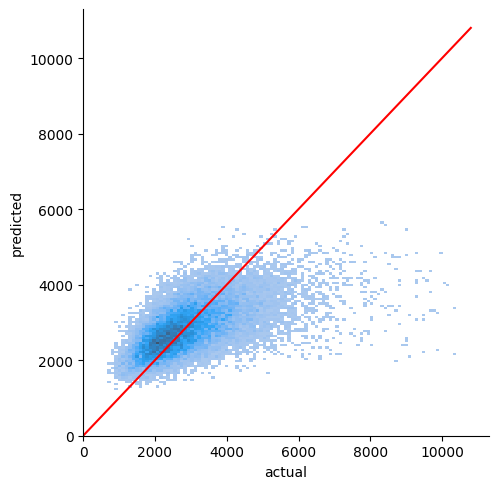

In [35]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

# Inference

In [39]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

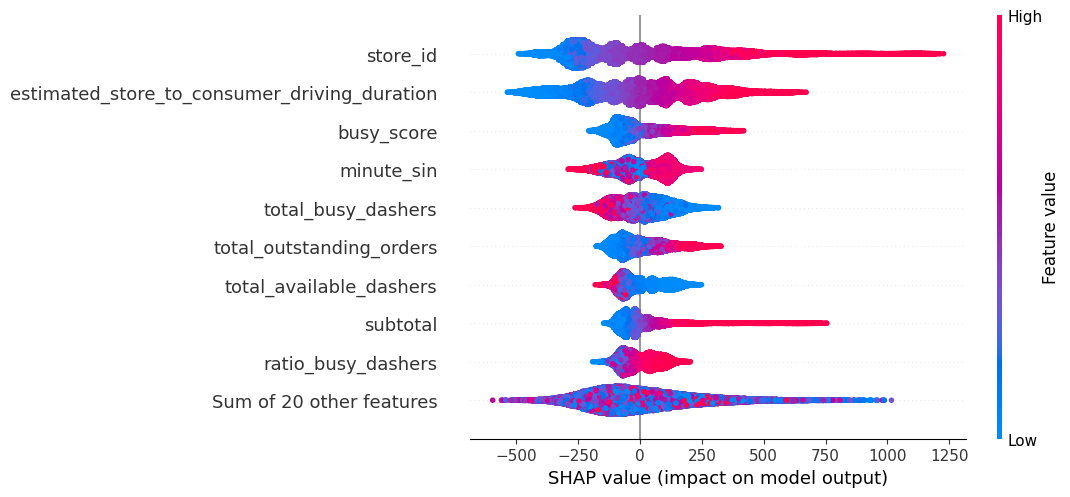

In [40]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

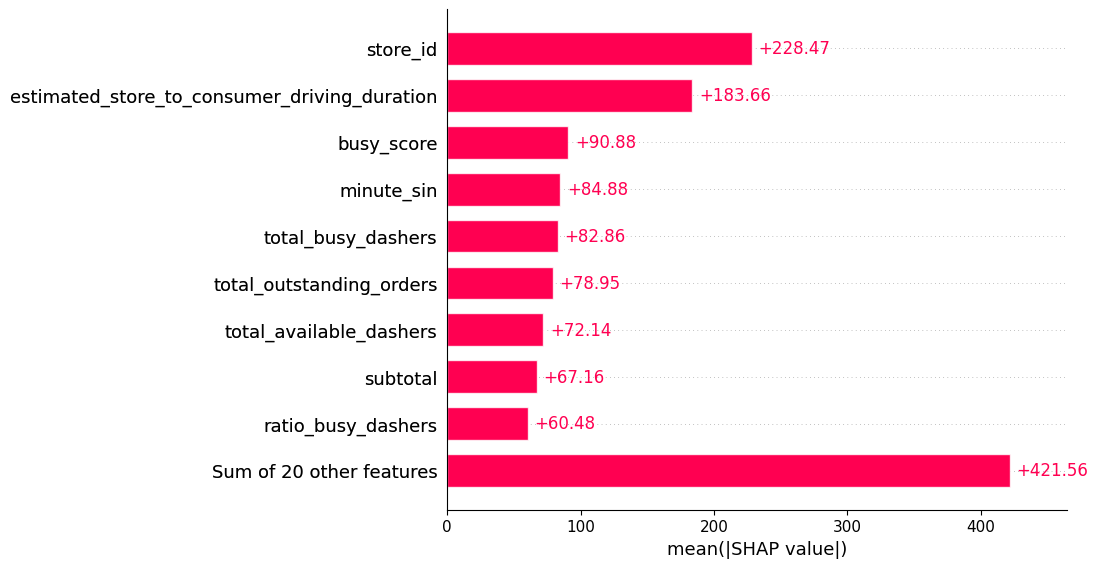

In [41]:
shap.plots.bar(shap_values)

# Findings
- Very similar overall to XGBoost.
- More importance on store_id.